Columns in LAS file:Index(['DEPTH', 'GR', 'RT', 'NPHI', 'SW', 'PHIE', 'VCL', 'RHOBMOD', 'DTSM',
       'DT', 'PIMPMOD', 'SIMPMOD', 'VPVSMOD'],
      dtype='object')


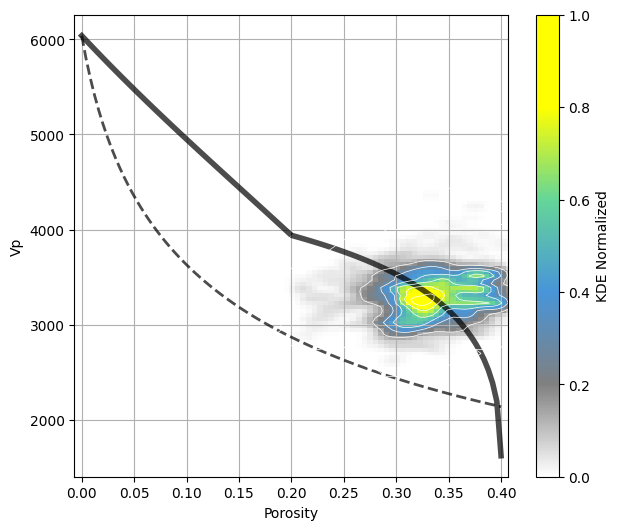

In [4]:
import lasio
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import grid
from bokeh.models import ColumnDataSource, CustomJS, Button, DataTable, TableColumn, HoverTool
from bokeh.models import LinearColorMapper, ColorBar, BasicTicker
import numpy as np
from rockphypy import QI

# Load data from .las file
las_file_path = 'EJEM1.las'  # Replace with your .las file path
las = lasio.read(las_file_path)

# Convert LAS file to a Pandas DataFrame
data = las.df()
data.reset_index(inplace=True)  # Convert depth/index to a column
print(f"Columns in LAS file:{data.columns}") # Print columns to see what columns are available in the LAS file.

# Ensure required columns are present
required_columns = ['PIMPMOD', 'VPVSMOD', 'DEPTH', 'NPHI', 'VCL', 'DT']
if not all(col in data.columns for col in required_columns):
    raise ValueError(f"LAS file must contain the following curves: {required_columns}")

# Rename columns if necessary (adjust based on your LAS file's curve names)
data.rename(columns={
    'PIMP': 'PIMPMOD',  # Replace with the actual curve name for P-Impedance
    'VPVS1': 'VPVSMOD',  # Replace with the actual curve name for Vp/Vs
    'DEPTH1': 'DEPTH',  # Replace with the actual curve name for Depth
    'VP' : 'Vp',
}, inplace=True)


# Set up ColumnDataSource for Bokeh
# Note: I have updated the ColumnDataSource to use the *original* required columns from the LAS file, instead of the renamed ones.
s1 = ColumnDataSource(data=dict(x=data.PIMPMOD, y=data.VPVSMOD, z=data.DEPTH, color=data.VPVSMOD))

# Set up color mapper
color_mapper = LinearColorMapper(palette="Turbo256", low=min(data.VPVSMOD), high=max(data.VPVSMOD))

# Create Bokeh figures
fig01 = figure(
    width=400,
    height=800,
    tools=["lasso_select", "reset", "save", "box_zoom", "wheel_zoom"],
    title="Select Here",
    x_axis_label="P-Impedance [m/s*g/cc]",
    y_axis_label="VpVs [unitless]"
)
circle_renderer = fig01.circle("x", "y", source=s1, alpha=0.6, color=dict(field="y", transform=color_mapper))
color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(), label_standoff=12, border_line_color=None, location=(0, 0))
fig01.add_layout(color_bar, 'right')

# Create second subplot
s2 = ColumnDataSource(data=dict(x=data.PIMPMOD, y=data.VPVSMOD))
y_min, y_max = min(data.VPVSMOD), max(data.VPVSMOD)
fig02 = figure(
    width=400,
    height=800,
    y_range=(y_min, y_max),
    tools=["box_zoom", "wheel_zoom", "reset", "save"],
    title="By sample polygon selection",
    x_axis_label="P-Impedance [m/s*g/cc]",
    y_axis_label="VpVs [unitless]"
)
fig02.circle("x", "y", source=s2, alpha=0.9, color="firebrick")

# Create third subplot
s3 = ColumnDataSource(data=dict(x=data.VPVSMOD, z=data.DEPTH))
y_min, y_max = min(data.DEPTH), max(data.DEPTH)
fig03 = figure(
    width=400,
    height=800,
    y_range=(y_min, y_max),
    tools=["box_zoom", "wheel_zoom", "reset", "save"],
    title="By sample polygon selection",
    x_axis_label="P-Impedance [m/s*g/cc]",
    y_axis_label="Depth [m]"
)
fig03.line('x', 'z', source=s1, alpha=0.7, color="black")
fig03.y_range.start, fig03.y_range.end = fig03.y_range.end, fig03.y_range.start  # Flip y-axis

# Create dynamic table of selected points
columns = [
    TableColumn(field="x", title="P-Impedance [m/s*g/cc]"),
    TableColumn(field="y", title="VpVs [unitless]"),
    TableColumn(field="z", title="Depth [m]"),
]
table = DataTable(
    source=s1,
    columns=columns,
    width=400,
    height=800,
    sortable=True,
    selectable=True,
    editable=True,
)

# JavaScript callback for lasso selection
s1.selected.js_on_change(
    "indices",
    CustomJS(
        args=dict(s1=s1, s2=s2, s3=s3, table=table),
        code="""
        var inds = cb_obj.indices;
        var d1 = s1.data;
        var d2 = s2.data;
        var d3 = s3.data;

        d2['x'] = [];
        d2['y'] = [];
        d2['z'] = [];

        for (var i = 0; i < inds.length; i++) {
            d2['x'].push(d1['x'][inds[i]]);
            d2['y'].push(d1['y'][inds[i]]);
            d2['z'].push(d1['z'][inds[i]]);
        }
        s2.change.emit();
        s3.change.emit();
        table.change.emit();
        """
    ),
)

# Save button to export selected data
savebutton = Button(label="Save", button_type="success")
savebutton.js_on_click(CustomJS(
    args=dict(source_data=s1),
    code="""
        var inds = source_data.selected.indices;
        var data = source_data.data;
        var out = "x, y, z\\n";
        for (var i = 0; i < inds.length; i++) {
            out += data['x'][inds[i]] + "," + data['y'][inds[i]] + "," + data['z'][inds[i]] + "\\n";
        }
        var file = new Blob([out], {type: 'text/plain'});
        var elem = window.document.createElement('a');
        elem.href = window.URL.createObjectURL(file);
        elem.download = 'selected-data.txt';
        document.body.appendChild(elem);
        elem.click();
        document.body.removeChild(elem);
        """
))

# Add hover tool
tooltips = [
    ("X:", "@x"),
    ("Y:", "@y"),
    ("Z:", "@z"),
]
fig02.add_tools(HoverTool(tooltips=tooltips))
fig03.add_tools(HoverTool(tooltips=tooltips))

# Display layout
layout = grid([fig01, fig02, fig03, table, savebutton], ncols=5)
output_notebook()
show(layout)

# Rock physics modeling (unchanged)
Dqz, Kqz, Gqz = 2.65, 36.6, 45
Dsh, Ksh, Gsh = 2.7, 21, 7
Dc, Kc, Gc = 2.65, 36.6, 45
Db, Kb = 1, 2.2
Do, Ko = 0.8, 1.5
Dg, Kg = 0.2, 0.06
phi_c = 0.4
sigma = 20
scheme = 2
Cn = 8.6
vsh = 0
phib_p = 0.2
f = 0.5

phi, vp1, vp2, vp3, vs1, vs2, vs3 = QI.screening(Dqz, Kqz, Gqz, Dsh, Ksh, Gsh, Dc, Kc, Gc, Db, Kb, phib_p, phi_c, sigma, vsh, scheme, f, Cn)

# Create an object with data, using the correct column names
qi = QI(data.DT, phi=data.NPHI, Vsh=data.VCL)

# Call the screening plot method
fig = qi.kde_plot(phi, vp1, vp2, vp3)